### Import packages

Import of the packages that will be needed for the project.  This includes packages for data manipulation, sklearn modules and custom functions.

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, FunctionTransformer, PowerTransformer

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor


In [2]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action = 'ignore')

In [3]:
pip install pandas==1.2.0

### Import Data

Let's import the dataframe that we will be using for modelling

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data = pd.read_csv('drive/MyDrive/LHL_Final_Project/Data/weekly_data.csv')
data.head()

,Unnamed: 0,Unnamed: 0.1,GameKey,PlayerID,Season,GameDate,Week,Team,Opponent,HomeOrAway,Number,Name,Position,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,FantasyPointsPPR,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,InjuryStatus,MatchString,HomeTeam,HomePoints,HomeYards,AwayTeam,AwayPoints,AwayYards
0,0,0,201810122,8283,2018,2018-09-09T13:00:00,1,TB,NO,AWAY,14,Ryan Fitzpatrick,QB,1,28.0,21.0,417.0,75.0,14.9,19.9,4.0,0.0,156.25,58.0,0.0,0.0,12.0,36.0,3.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.28,0.0,0.0,0.0,0.0,0.0,NaN,20181TBNO,NO,40.0,475.0,TB,48.0,529.0
1,1,1,201810122,18878,2018,2018-09-09T13:00:00,1,NO,TB,HOME,41,Alvin Kamara,RB,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,8.0,29.0,3.6,2.0,10.0,12.0,9.0,112.0,12.4,1.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,43.10,0.0,0.0,0.0,0.0,0.0,NaN,20181TBNO,NO,40.0,475.0,TB,48.0,529.0
2,2,2,201810122,7242,2018,2018-09-09T13:00:00,1,NO,TB,HOME,9,Drew Brees,QB,1,45.0,37.0,439.0,82.2,9.8,11.9,3.0,0.0,129.54,35.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,31.56,0.0,0.0,0.0,0.0,0.0,NaN,20181TBNO,NO,40.0,475.0,TB,48.0,529.0
3,4,4,201810129,18082,2018,2018-09-09T16:05:00,1,KC,LAC,AWAY,10,Tyreek Hill,WR,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,2.0,4.0,2.0,0.0,7.0,8.0,7.0,169.0,24.1,2.0,58.0,0.0,0.0,2.0,95.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.30,0.0,0.0,0.0,0.0,0.0,NaN,20181KCLAC,LAC,28.0,541.0,KC,38.0,362.0
4,5,5,201810108,18983,2018,2018-09-09T13:00:00,1,PIT,CLE,AWAY,30,James Conner,RB,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,31.0,135.0,4.4,2.0,22.0,6.0,5.0,57.0,11.4,0.0,19.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.20,0.0,0.0,0.0,0.0,0.0,NaN,20181PITCLE,CLE,21.0,327.0,PIT,21.0,472.0


In [6]:
data['Week'] = data['Week'].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31538 entries, 0 to 31537
Data columns (total 65 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    31538 non-null  int64  
 1   Unnamed: 0.1                  31538 non-null  int64  
 2   GameKey                       31538 non-null  int64  
 3   PlayerID                      31538 non-null  int64  
 4   Season                        31538 non-null  int64  
 5   GameDate                      31538 non-null  object 
 6   Week                          31538 non-null  object 
 7   Team                          31538 non-null  object 
 8   Opponent                      31538 non-null  object 
 9   HomeOrAway                    31538 non-null  object 
 10  Number                        31538 non-null  int64  
 11  Name                          31538 non-null  object 
 12  Position                      31538 non-null  object 
 13  S

In [7]:
# Get a list of unique player names in the dataset for use in the one hot
# encoder in our data prep pipeline

unique_players = data['Name'].unique().tolist()
len(unique_players)

1245

Before the train test split, we have to calculate the trailing average fantasy points for each observation, as we cannot incorporate this step into the pipeline without causing data leakage.

In [8]:
import pandas as pd
import numpy as np

def offensive_contribution(home_away, total_yards, home_yards, away_yards):
    
    """
    Calculate a percentage for the percentage of team yards that a player contributes to.
    
    Input:  
        - Dataframe to use in the calculation
        
    Output:
        - New dataframe column with the desired contribution score
    """
    
    if home_away == 'HOME':
        contribution =  total_yards / home_yards
        if contribution > 1:
             return 1.0
        else:
            return contribution
            
    elif home_away == 'AWAY':
        contribution =  total_yards / away_yards
        if contribution > 1:
              return 1.0
        else:
            return contribution
        
        
def get_contribution(df):
    
    df['YardageContribution'] = df.apply(lambda x: offensive_contribution(x['HomeOrAway'],
                                                                         x['TotalYards'],
                                                                         x['HomeYards'],
                                                                         x['AwayYards']),
                                        axis = 1)
    return df

#---------------------------------------------------------
# Define the stats for which we need to calculate trailing averages
stats_for_trailing = ['TotalTouchdowns','RushingYards','PassingInterceptions','PassingTouchdowns','PassingRating','PassingYards',
                      'PassingCompletionPercentage', 'PassingLong','RushingYards', 'RushingTouchdowns', 'RushingLong',
                      'RushingYardsPerAttempt', 'ReceivingYardsPerReception', 'PuntReturns', 'PuntReturnTouchdowns',
                      'Receptions','ReceivingYards','ReceivingTargets', 'ReceivingTouchdowns', 'ExtraPointsMade', 'FieldGoalsMade',
                      'FieldGoalsMade40to49','FieldGoalsMade50Plus','Fumbles','FumblesLost']


def trailing_stats_mean(df):
    
    """
    Function to create a new column with a trailing aggregate mean
    as a new feature for prediction.
    
    Inputs:
        - df: The dataframe on which the function will be applied
        - Column: The column on which to apply the function
        - Window: The number of past values to consider when apply the function

        
    Output:
        - An aggregate value
        
    """
    #Access the column names in stats_for_trailing
    global stats_for_trailing
    
    # Get all unique players in the DataFrame
    players = df['Name'].unique().tolist()
    
    # Define a DataFrame to hold our values
    df_out = pd.DataFrame()
    # Loop through the unique players
    for player in players:
        # Create a temporary dataframe for each player
        temp_df = df[df['Name'] == player]
        # Calculate the n game trailing average for all players.  Set closed parameter to 'left'
        # so that the current value for fantasy points is not included in the calculation.
        # Backfill the two resulting NaN values
        for column in stats_for_trailing:
            temp_df[f'TA{column}'] = temp_df[column].rolling(window = 7, 
                                                              closed = 'left').mean().fillna(method = 'bfill')
        # Append the temporary dataframe to the output
        df_out = df_out.append(temp_df)
    # Return a dataframe with the values sorted by the original index
    df_out.sort_index(inplace = True)
    return df_out.sort_index()
    
#---------------------------------------------------------

def tier_maker(position, points):
    
    """
    Take in two arguments:
    
     - Position: Column of the dataframe holding the player position
     - Points: Trailing average of fantasy points for a given player
    
    Classify players at every position to a tier based on their recent 
    performance (Trailing average fantasy points). Classifications will work
    as follows.
    
    Running Back:
        -RB1: Trailing average greater than 18pts
        -RB2: Trailing average between 12 and 18 pts
        -RB3: Trailing average between 8 and 12 pts
        -RB4: Trailing average below 8 pts
        
    Wide Receiver:
        -WR1: Trailing average greater than 18pts
        -WR2: Trailing average between 12 and 18 pts
        -WR3: Trailing average between 8 and 12 pts
        -WR4: Trailing average below 8 pts
        
    Tight End:
        -TE1: Trailing average greater than 15pts
        -TE2: Trailing average between 10 and 15 pts
        -TE3: Trailing average below 10 pts
        
    Quarterback:
        -QB1: Trailing average greater than 24pts
        -QB2: Trailing average between 18 and 24pts
        -QB3: Trailing average between 12 and 18pts
        -QB4: Trailing average below 12 pts
    
    Kicker:
        - K1: Trailing average greater than 10 pts
        - K2: Trailing average between 7 and 10 points
        - K3: Trailing average below 7 points
        """

    # Let's make tier assignments for running backs
    if position == 'RB':
        if points > 18:
            return 'RB1'
        elif 10 < points <= 18:
            return 'RB2'
        elif 4 < points <= 10:
            return 'RB3'
        else:
            return 'RB4'
            
    # Let's make tier assignments for wide receivers
    if position == 'WR':
        if points > 16:
            return 'WR1'
        elif 10 < points <= 16:
            return 'WR2'
        elif 4 < points <= 10:
            return 'WR3'
        else:
            return 'WR4'
            
    # Let's make tier assignments for tight ends
    if position == 'TE':
        if points > 12:
            return 'TE1'
        elif 6 < points <= 12:
            return 'TE2'
        else:
            return 'TE3'
    
    # Let's make tier assignments for quarterbacks
    if position == 'QB':
        if points > 24:
            return 'QB1'
        elif 18 < points <= 24:
            return 'QB2'
        elif 10 < points <= 18:
            return 'QB3'
        else:
            return 'QB4'

    # Let's make tier assignments for kickers
    if position == 'K':
        if points > 9:
            return 'K1'
        elif 4 < points <= 9:
            return 'K2'
        else:
            return 'K3'
    
    # If noting is returned before this point, return np.nan
    return np.nan
#---------------------------------------------------------------------

def get_tiers(df):
    
    """
    Apply the tier_maker function to the entire dataframe.
    """
    
    df['PlayerTier'] = df.apply(lambda x: tier_maker(x['Position'], x['TAFantasyPointsPPR']),
                               axis = 1)
    return df
#---------------------------------------------------------------------

def get_touchdowns(df):
    
    """
    Get the total number of touchdowns for a player in a given week.
    
    Input:
        - Dataframe
    Output:
        - Dataframe with a new column representing total touchdowns"""
    
    TD_sum = df['ReceivingTouchdowns'] + df['RushingTouchdowns'] + df['PassingTouchdowns']
    df['TotalTouchdowns'] = TD_sum
    
    return df

#----------------------------------------------------------------------

def get_yards(df):
    
    """
    Get the total number of yards for a player in a given week.
    
    Input:
        - Dataframe
    Output:
        - Dataframe with a new column representing total touchdowns"""
    
    yardage_sum = df['ReceivingYards'] + df['RushingYards'] + df['PassingYards']
    df['TotalYards'] = yardage_sum
    
    return df

#-------------------------------------------------------------------------

def LogShift(X):

    """
    Function designed to add a constant of 10 to all continuous features followed
    by a log transform.  Intended to normalize right-skewed dataset.
    
    Input:
        - Dataframe of continuous variables.
    Output:
        - Log-Scaled Dataframe"""
    
    X_10 = X + 10
    X_log = np.log(X_10)
    
    return X_log

In [9]:
stats_for_trailing = ['FantasyPointsPPR']
data = trailing_stats_mean(data)


### Train Test Split

In [10]:
# Separate data from the target
y = LogShift(data['FantasyPointsPPR'])
data.drop(columns = ['FantasyPointsPPR'],
            inplace = True)
X = data

In [11]:
# Execute the train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.3,
                                                   random_state = 13,
                                                    shuffle = False)

### Feature Engineering

The main features that we will be engineering to predict a player's fantasy output will be the 5-game trailing average of various statistics as well as the binning of players into their respective tiers based on recent performance.

In [12]:
# Define the columns for which we want a 5 game trailing average.

stats_for_trailing = ['TotalTouchdowns','RushingYards','PassingInterceptions','PassingTouchdowns','PassingRating','PassingYards',
                      'PassingCompletionPercentage', 'PassingLong','RushingYards', 'RushingTouchdowns', 'RushingLong',
                      'RushingYardsPerAttempt', 'ReceivingYardsPerReception', 'PuntReturns', 'PuntReturnTouchdowns',
                      'Receptions','ReceivingYards','ReceivingTargets', 'ReceivingTouchdowns', 'ExtraPointsMade', 'FieldGoalsMade',
                      'FieldGoalsMade40to49','FieldGoalsMade50Plus','Fumbles','FumblesLost']

trailing_stats = []
for col in stats_for_trailing:
    trailing_stats.append('TA' + col)
trailing_stats.append('TAFantasyPointsPPR')

In [13]:
# Instantiate the function transformers for the feature engineering pipeline

touchdown_transformer = FunctionTransformer(get_touchdowns) # Get total touchdowns per week per player
yard_transformer = FunctionTransformer(get_yards) # Get total yardage per week per player
trailing_transformer = FunctionTransformer(trailing_stats_mean) # Get the 5 game trailing averages of appropriate statistics
tier_transformer = FunctionTransformer(get_tiers) # Bin players into the appropriate tiers based on recent performance
contribution_transformer = FunctionTransformer(get_contribution) # Calculate the offensive contribution of a given player relative to the team's offense


# Instantiate the pipeline for the necessary transformations

engineering = Pipeline([('touchdown', touchdown_transformer),
                        ('yards', yard_transformer),
                       ('trailing', trailing_transformer),
                       ('tier', tier_transformer),
                       ('contribution', contribution_transformer)])

In [14]:
# Build a new transformer class to convert the sparse matrix output of the 
# pipeline to a dense matrix compatible with the NN

class DenseTransformer(TransformerMixin):

    def fit(self, X, y = None, **fit_params):
        return self

    def transform(self, X, y = None, **fit_params):
        return X.todense()

In [15]:
# Create an instance of the logshift transformer

LogShiftTransformer = FunctionTransformer(LogShift)

<br>

### Preprocessing

As shown above, the bulk of the null values fall into one of two categories.  They are either:
* In the InjuryStatus column
    * Here we can impute a value of healthy, as the only values in the injury column are 
* In the TA (trailing average) columns we created
    * No player with a null value played more than 5 games, therefore we cannot calculate the trailing average for them.  We will impute a default value of 0 for these columns, as they represent players who likely did not have much impact.  If they had an impact, they likely would have played in more games.  I will explore imputing the median value as well through a grid search.

In [16]:
# Define the groups of columns for preprocessing steps.

categorical_columns = ['Week',
                    #    'Name',
                       'Team',
                       'Opponent',
                       'PlayerTier']
numerical_columns = trailing_stats


In [17]:
# Define the preprocessing steps for categorical features
categorical_transform = Pipeline([('impute_cat',SimpleImputer(strategy = 'most_frequent')),
                                 ('one_hot_encoder', OneHotEncoder(handle_unknown = 'ignore'))])

# Define the preprocessing steps for numerical features
numerical_transform = Pipeline([('impute_num', SimpleImputer(strategy = 'constant', fill_value = 0)), ('scaler', LogShiftTransformer)])

# Instantiate the column transformer object for the preprocessing steps
preprocessing = ColumnTransformer([('num', numerical_transform, numerical_columns),
                                  ('cat', categorical_transform, categorical_columns)])

In [18]:
eng_prep_pipe = Pipeline([('engineering', engineering),
                          ('prep', preprocessing)])

df_train = eng_prep_pipe.fit_transform(X_train)
df_test = eng_prep_pipe.fit_transform(X_test)


In [19]:
df_test  = df_test.todense()
df_train = df_train.todense()

In [20]:
def create_model(optimizer = 'Adam'):

    model = Sequential()
    model.add(Dense(64, input_dim = df_train.shape[1], activation = 'sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation = 'relu'))
    # model.add(Dense(1024, activation = 'tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(8, activation = 'sigmoid'))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = optimizer)
    print(model.summary())
    return model

In [21]:
# Instantiate a pipeline with a linear regression model as a baseline

model = KerasRegressor(build_fn = create_model,
                                             epochs = 100,
                                             batch_size = 64,
                                             verbose = 2)

In [22]:
pipeline = Pipeline([('engineering', engineering),
                     ('prep', preprocessing),
                     ('todense', DenseTransformer()),
                      ('network', model)])

In [23]:
# Set param grid values, parameters for grid search 

param_grid = {}

grid_search = GridSearchCV(model, 
                          param_grid = param_grid,
                          cv = 3,
                          verbose = 2,
                          n_jobs = -2)

In [24]:


history = model.fit(df_train, y_train,
                    validation_data = (df_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                8064      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 512)               33280     
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [25]:
history

In [26]:
# preds = grid_search.predict(X_test)
preds = model.predict(df_test)

148/148 - 0s - 309ms/epoch - 2ms/step


In [27]:
r2_score(y_test, preds)

0.4704464391656289

In [28]:
mean_squared_error(y_test, preds)

0.08641154886162469

In [29]:
mean_absolute_error(y_test, preds)

0.21748629056251242

Let's dig into the predictions a little bit

In [30]:
df_preds = pd.DataFrame(y_test)

In [31]:
df_preds['LogPredicted'] = preds
df_preds['Predicted'] = (np.exp(df_preds['LogPredicted']) - 10).round(2)
df_preds['Target'] = (np.exp(df_preds['FantasyPointsPPR']) - 10).round(2)
df_preds.sample(20)

,FantasyPointsPPR,LogPredicted,Predicted,Target
26008,3.104587,2.672448,4.480000,12.30
23768,2.708050,2.560329,2.940000,5.00
22909,2.302585,2.352423,0.510000,0.00
28574,2.302585,2.363783,0.630000,0.00
23051,3.274878,3.439041,21.160000,16.44
30558,2.302585,2.363631,0.630000,0.00
27688,3.299534,2.947631,9.060000,17.10
29416,2.595255,2.677092,4.540000,3.40
25304,2.302585,2.576660,3.150000,0.00
22649,3.169686,2.955158,9.200000,13.80


In [32]:
r2_score(df_preds['Target'], df_preds['Predicted'])

0.41801260225378867

In [33]:
mean_squared_error(df_preds['Target'], df_preds['Predicted'])

32.593469880662646

In [34]:
mean_absolute_error(df_preds['Target'], df_preds['Predicted'])

3.7035351903923366

# Time to do some digging to see where the model fails


In [35]:
df_review = X_test
df_review['Predicted'] = df_preds['Predicted']
df_review['Target'] = df_preds['Target']
df_review['Error'] = df_review['Target'] - df_review['Predicted']
df_review.head()

,Unnamed: 0,Unnamed: 0.1,GameKey,PlayerID,Season,GameDate,Week,Team,Opponent,HomeOrAway,Number,Name,Position,Started,PassingAttempts,PassingCompletions,PassingYards,PassingCompletionPercentage,PassingYardsPerAttempt,PassingYardsPerCompletion,PassingTouchdowns,PassingInterceptions,PassingRating,PassingLong,PassingSacks,PassingSackYards,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,RushingLong,ReceivingTargets,Receptions,ReceivingYards,ReceivingYardsPerReception,ReceivingTouchdowns,ReceivingLong,Fumbles,FumblesLost,PuntReturns,PuntReturnYards,PuntReturnTouchdowns,KickReturns,KickReturnYards,KickReturnTouchdowns,FieldGoalsAttempted,FieldGoalsMade,ExtraPointsMade,TwoPointConversionPasses,TwoPointConversionRuns,TwoPointConversionReceptions,FieldGoalsMade0to19,FieldGoalsMade20to29,FieldGoalsMade30to39,FieldGoalsMade40to49,FieldGoalsMade50Plus,InjuryStatus,MatchString,HomeTeam,HomePoints,HomeYards,AwayTeam,AwayPoints,AwayYards,TAFantasyPointsPPR,TotalTouchdowns,TotalYards,Predicted,Target,Error
22076,71226,102,202011011,20873,2020,2020-11-15T13:00:00,10,WAS,DET,AWAY,17,Terry McLaurin,WR,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1.0,27.0,27.0,0.0,27.0,9.0,7.0,95.0,13.6,0.0,26.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,202010WASDET,DET,30.0,372.0,WAS,27.0,464.0,18.057143,0.0,122.0,12.40,17.20,4.80
22077,71227,103,202011019,19824,2020,2020-11-15T16:05:00,10,LAC,MIA,AWAY,11,Kalen Ballage,RB,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,18.0,68.0,3.8,0.0,11.0,6.0,5.0,34.0,6.8,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,202010LACMIA,MIA,29.0,280.0,LAC,21.0,273.0,7.100000,0.0,102.0,7.01,15.20,8.19
22078,71228,104,202011022,19330,2020,2020-11-15T16:25:00,10,SF,NO,AWAY,4,Nick Mullens,QB,1,38.0,24.0,247.0,63.2,6.5,10.3,1.0,2.0,68.64,27.0,2.0,15.0,1.0,3.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,202010SFNO,NO,27.0,237.0,SF,13.0,281.0,7.554286,1.0,250.0,0.56,10.18,9.62
22079,71229,105,202011034,22112,2020,2020-11-12T20:20:00,10,IND,TEN,AWAY,3,Rodrigo Blankenship,K,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,NaN,202010INDTEN,TEN,17.0,294.0,IND,34.0,430.0,8.857143,0.0,0.0,7.54,10.00,2.46
22080,71231,107,202011012,21542,2020,2020-11-15T13:00:00,10,JAX,GB,AWAY,5,Chase McLaughlin,K,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,202010JAXGB,GB,24.0,395.0,JAX,20.0,260.0,7.000000,0.0,0.0,6.92,10.00,3.08


In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

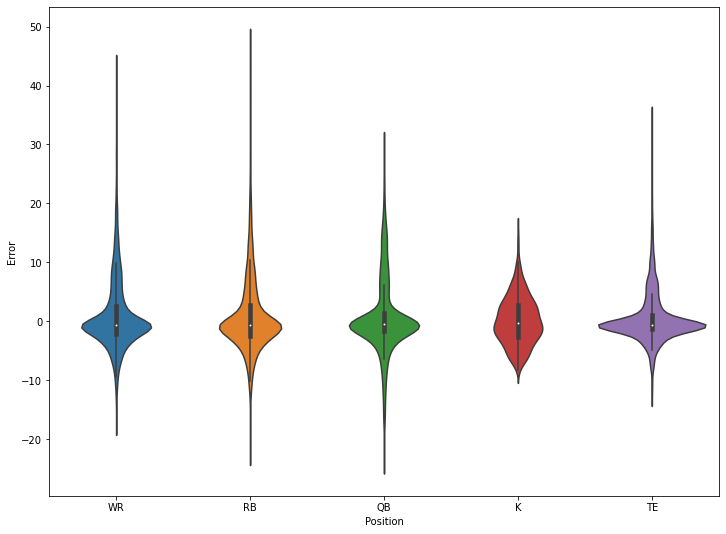

In [37]:
# Let's visualize how the prediction error varies by player position.

plt.figure(figsize = (12, 9))
sns.violinplot(x = df_review['Position'],
               y = df_review['Error'])

From the above plot we can see that for the bulk of positions, the error is quite tightly distributed around a mean of 0.  However, with kickers we can see that the error is more widely spread.  <br> In all cases, the error is skewed to being more positive than negative.

In [38]:
# Let's apply our engineered features to df_review and keep on digging
df_review = trailing_stats_mean(df_review)
df_review['PlayerTier'] = df_review.apply(lambda x: tier_maker(x['Position'], x['TAFantasyPointsPPR']), axis = 1)
df_review['AbsoluteError'] = abs(df_review['Error'])

In [39]:
mean_tier_error = df_review[['PlayerTier', 'Error', 'AbsoluteError']].groupby('PlayerTier').mean()
sum_tier_error = df_review[['PlayerTier', 'Error','AbsoluteError']].groupby('PlayerTier').sum()
count_tier_error = df_review[['PlayerTier', 'Error']].groupby('PlayerTier').count()
mean_tier_error['Total Absolute Error'] = sum_tier_error['AbsoluteError']
mean_tier_error['Total Error'] = sum_tier_error['Error']
mean_tier_error['Error Count'] = count_tier_error['Error']
mean_tier_error.rename({'Error': 'Mean Error'}, 
                       axis = 1)

,Mean Error,AbsoluteError,Total Absolute Error,Total Error,Error Count
PlayerTier,,,,,
K1,-0.212111,2.943222,264.889997,-19.090003,90
K2,0.000852,3.319830,1364.450002,0.350000,411
K3,1.082778,3.281889,295.370000,97.449999,90
QB1,-2.432037,7.478333,403.829996,-131.329995,54
QB2,0.456541,7.069119,1123.989985,72.590008,159
QB3,2.038595,7.400992,1791.040005,493.340002,242
QB4,0.470720,2.588750,2443.780000,444.360000,944
RB1,1.099778,7.474444,672.700000,98.979993,90
RB2,1.360637,6.740424,2541.139994,512.960002,377
